In [3]:
import os
import shutil
from bs4 import BeautifulSoup
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import time
from sklearn.model_selection import train_test_split

# DATA EXTRACTION

In [8]:
cwd = os.getcwd() +"/"
print(cwd)

C:\Users\newgh\1 jupiter\machine learning\Computer Vision\pcb\pcb detect&classify/


In [ ]:
import shutil
data_path = os.path.join(cwd,"unetdataset")
shutil.rmtree(data_path)

FileNotFoundError: ignored

In [5]:
data_path = os.path.join(cwd,"unetdataset")
os.mkdir(data_path)
for t in ["train","test"]:
  try : 
    path = os.path.join(data_path,t)
    os.mkdir(path)
    print(t," created")
  except :
    print(t," already exist")
  try :
    os.mkdir(os.path.join(path,"input"))
    print("--| input created")
  except :
    print("--| input already exist")
  try :
    os.mkdir(os.path.join(path,"output"))
    print("--| output created")
  except :
    print("--| output already exist")

train  created
--| input created
--| output created
test  created
--| input created
--| output created


In [7]:
annot = cwd + '/annot'
annots = os.listdir(annot)
annots = [pcb for pcb in annots if not("Bottom" in pcb)]
annotations=[]
total_componenets = 0
for a in annots:
    item = {}
    item['file_name'] = a.split('.')[0]
    gtBoxes=[]
    labels=[]
    path = annot+"/"+a
    contents = open(path).read()
    soup = BeautifulSoup(contents, "html.parser")
    w = int(soup.find("width").string)
    h = int(soup.find("height").string)
    objects = []
    for o in soup.find_all("object"):
        label = o.find("name").string.split()[0]
        if label[0] == '"':
            label = label[1:]
        if not(label in ["battery", "zener", "transformer", "fuse", "text", "heatsink", "display", "buzzer", "potentiometer"]):
          xMin = int(o.find("xmin").string)
          yMin = int(o.find("ymin").string)
          xMax = int(o.find("xmax").string)
          yMax = int(o.find("ymax").string)
          xMin = max(0, xMin)
          yMin = max(0, yMin)
          xMax = min(w, xMax)
          yMax = min(h, yMax)
          total_componenets +=1
          objects.append((label,(xMin, yMin, xMax, yMax)))
    item['objects'] = objects
    annotations.append(item)
print(total_componenets)

6104


# DATA CREATION AND AUGMENTATION


In [9]:
def augmentpair_rotation(img,image_path,binary,binary_path,method,encoding):
  img_90 = cv2.rotate(img, method)
  img_90_path = image_path[:-4] + encoding + image_path[-4:]
  cv2.imwrite(img_90_path,img_90)

  binary_90 = cv2.rotate(binary, method)
  binary_90_path = binary_path[:-4] + encoding + binary_path[-4:]
  cv2.imwrite(binary_90_path,binary_90)

  return (img_90_path,binary_90_path) 

def augmentpair_flip(img,image_path,binary,binary_path,method,encoding):
  img_90 = cv2.flip(img, method)
  img_90_path = image_path[:-4] + encoding + image_path[-4:]
  cv2.imwrite(img_90_path,img_90)

  binary_90 = cv2.flip(binary, method)
  binary_90_path = binary_path[:-4] + encoding + binary_path[-4:]
  cv2.imwrite(binary_90_path,binary_90)

  return (img_90_path,binary_90_path) 

fininshed in  42.59606719017029


(-0.5, 559.5, 700.5, -0.5)

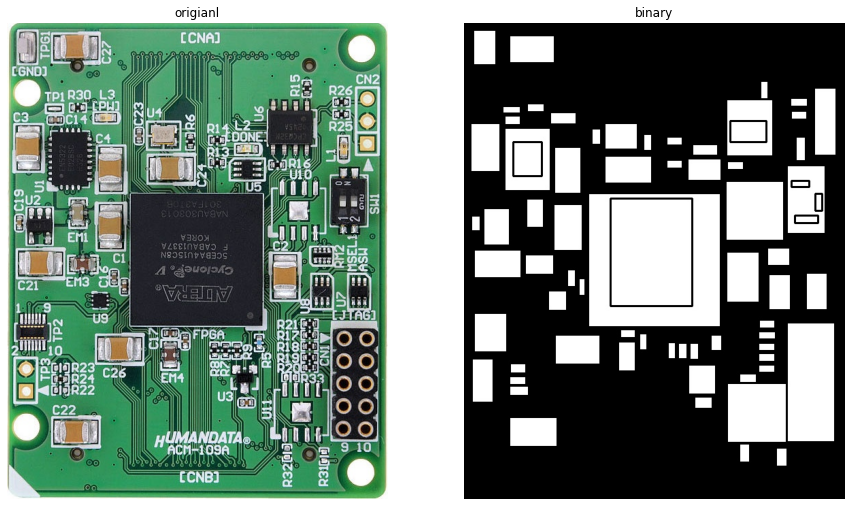

In [10]:
start = time.time()
origianl_images = []
binary_images = []
for a in annotations:
    image_name = a['file_name']+'.jpg'
    image_path = cwd + "images/" + image_name
    img=cv2.imread(image_path)
    components = a['objects']
    components = [c[1] for c in components]
    height , width = img.shape[:2]
    # generating binary counterparts 1 is a component and 0 background
    binary = np.zeros( (height,width) )
    for component in components :
        (xMin, yMin, xMax, yMax) = component
        cv2.rectangle(binary, (xMin, yMin), (xMax, yMax), 255, -1)
        cv2.rectangle(binary, (xMin, yMin), (xMax, yMax), 0, 2)
    # we will store the paths in order to limit memory usage and store the results in a folder labelled binaries 
    origianl_images.append(image_path)
    binary_path = cwd + "binaries/" +image_name[:-4] + "binary" + image_name[-4:]
    cv2.imwrite(binary_path,binary)
    binary_images.append(binary_path)
    # DATA AUGMENTATION
    # we wont be flipping for the limited data space however 
    # the same operation can be done with augmentpair_flip with (0,1,-1) as methods and ("0","1","_1") as encodings
    methods = (cv2.ROTATE_90_CLOCKWISE,cv2.ROTATE_90_COUNTERCLOCKWISE,cv2.ROTATE_180)
    encodings = ("90","_90","180")
    for i in range(3):
      i_path,b_path = augmentpair_rotation(img,image_path,binary,binary_path,methods[i],encodings[i])
      origianl_images.append(i_path)
      binary_images.append(b_path)
print("fininshed in ", time.time() - start)

# visualizing results 
fig = plt.figure(figsize=(15, 10))
rows = 1
columns = 2
fig.add_subplot(rows, columns, 1)
img = cv2.imread(origianl_images[0])
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.title("origianl")
plt.axis('off')
fig.add_subplot(rows, columns, 2)
binary = cv2.imread(binary_images[0])
plt.imshow(binary,cmap='gray')
plt.title("binary")
plt.axis('off')

In [11]:
FINAL_DIM = (160,160)

# get n random snippets to spice things up
def get_random_windows( original, binary, window_size, n):
  original = cv2.imread(original)
  binary = cv2.imread(binary)
  global FINAL_DIM
  height, width = original.shape[:2]
  original_windows = []
  binary_windows = []
  for i in range(n):
    start = random.randint(0,height-window_size)
    end = random.randint(0,width-window_size)
    o = cv2.resize(original[start : start + window_size , end : end + window_size],FINAL_DIM,interpolation = cv2.INTER_AREA)
    b = cv2.resize(binary[start : start + window_size , end : end + window_size],FINAL_DIM,interpolation = cv2.INTER_AREA)
    original_windows.append(o)
    binary_windows.append(b)
  return (original_windows,binary_windows)

def get_windows( original, binary, window_size):
  global FINAL_DIM
  # the limit to ingnoring the border in case 5 we don't consider what's at the right/bottom extrem if less then the fifth of the window size
  buffer_percentile = 5
  original = cv2.imread(original)
  binary = cv2.imread(binary)
  height, width = original.shape[:2]
  originals = []
  binaries = []
  # main body
  for j in range(0, height , window_size):
    for i in range(0 , width, window_size):
      o = cv2.resize(original[j : j + window_size , i : i + window_size],FINAL_DIM,interpolation = cv2.INTER_AREA)
      b = cv2.resize(binary[j : j + window_size , i : i + window_size],FINAL_DIM,interpolation = cv2.INTER_AREA)
      originals.append(o)
      binaries.append(b)
  
  # bottom extreme
  if height % window_size > window_size // buffer_percentile:
    for i in range(0 ,width, window_size):
      o = cv2.resize(original[height - window_size : height , i : i + window_size],FINAL_DIM,interpolation = cv2.INTER_AREA)
      b = cv2.resize(binary[height - window_size : height , i : i + window_size],FINAL_DIM,interpolation = cv2.INTER_AREA)
      originals.append(o)
      binaries.append(b)
  # right extreme
  if width % window_size > window_size // buffer_percentile:
    for i in range(0 ,height , window_size):
      o = cv2.resize(original[ i : i + window_size , width - window_size : width],FINAL_DIM,interpolation = cv2.INTER_AREA)
      b = cv2.resize(binary[i : i + window_size , width - window_size : width],FINAL_DIM,interpolation = cv2.INTER_AREA)
      originals.append(o)
      binaries.append(b)
  # right bottom corner 
  if (width % window_size > window_size // buffer_percentile) and (height % window_size > window_size // buffer_percentile):
    o = cv2.resize(original[height - window_size : height , width - window_size : width],FINAL_DIM,interpolation = cv2.INTER_AREA)
    b = cv2.resize(binary[height - window_size : height , width - window_size : width],FINAL_DIM,interpolation = cv2.INTER_AREA)
    originals.append(o)
    binaries.append(b)

  return originals , binaries

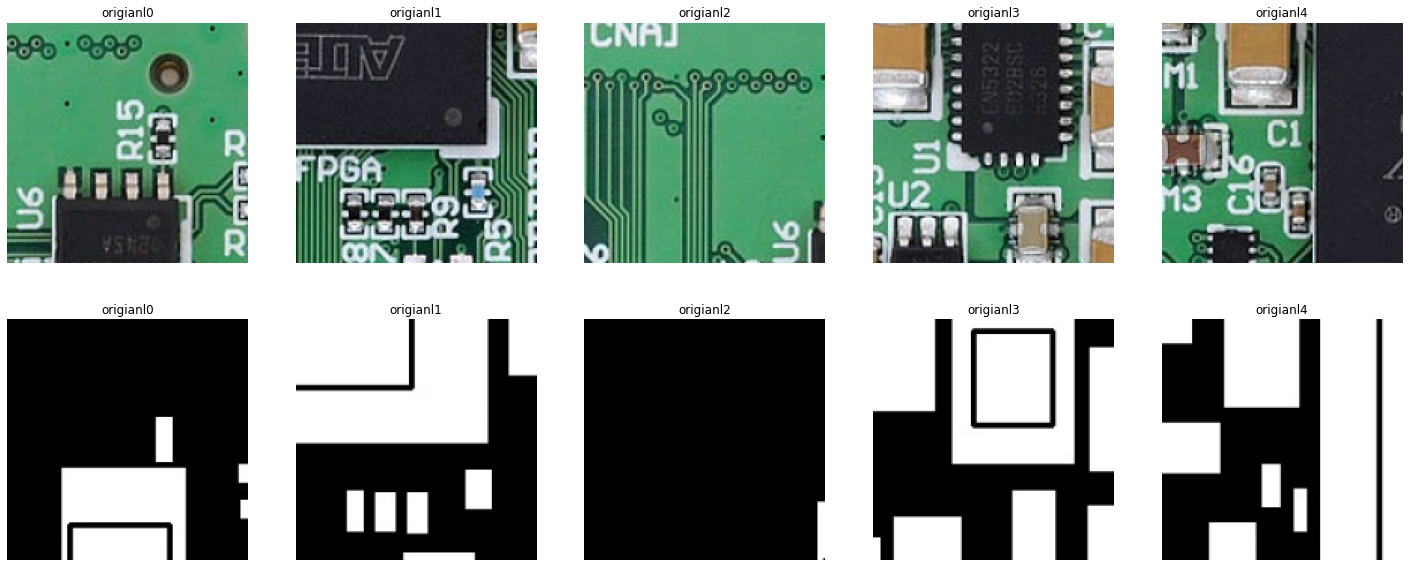

In [12]:
rows = 2
columns = 5
fig = plt.figure(figsize=(25, 10))
(originals, binaries) = get_random_windows(origianl_images[0],binary_images[0], 128,5)
for i in range(5):
  fig.add_subplot(rows, columns, i + 1)
  plt.imshow(cv2.cvtColor(originals[i],cv2.COLOR_BGR2RGB))
  plt.title("origianl" + str(i))
  plt.axis('off')
  fig.add_subplot(rows, columns, i + 6)
  plt.imshow(binaries[i],cmap='gray')
  plt.title("origianl" + str(i))
  plt.axis('off')

In [13]:
def extract_data(origianl_images,binary_images,directory):
  global cwd
  path = os.path.join(cwd,"unetdataset")
  path = os.path.join(path,directory)
  input_path = os.path.join(path,"input")
  
  output_path = os.path.join(path,"output") 
  start = time.time()
  # different window sizes to get different scale 
  window_sizes = (160, 240)
  for window_size in window_sizes:
    for i in range(len(origianl_images)):
      print(int(i*100/len(origianl_images)),"% ==> ",end="")
      original_windows = []
      binary_windows = []
      original = origianl_images[i]
      binary = binary_images[i]
      image_name = original.split("/")[-1]

      # uniform selection 
      (originals, binaries) = get_windows( original, binary, window_size)
      original_windows.extend(originals)
      binary_windows.extend(binaries)
      # random selection ( we will cheat a bit and give it the second window size since we won't be using it)
      (originals, binaries) = get_random_windows( original, binary, window_sizes[1],100)

      original_windows.extend(originals)
      binary_windows.extend(binaries)

      for j in range(len(original_windows)):
        image_name_j = image_name[:-4]+str(j)+str(window_size) +image_name[-4:]
        o = os.path.join(input_path,image_name_j)
        cv2.imwrite(o,original_windows[j])
        b = os.path.join(output_path,image_name_j)
        cv2.imwrite(b,binary_windows[j])
    print("complted for window size : ",window_size)

In [14]:
start =  time.time()
X_train, X_test, y_train, y_test = train_test_split(origianl_images,binary_images,test_size = 0.25)
extract_data(X_train, y_train,"train")
extract_data(X_test, y_test,"test")

print("finished in ", time.time() - start)

0 % ==> 1 % ==> 2 % ==> 3 % ==> 4 % ==> 5 % ==> 6 % ==> 7 % ==> 8 % ==> 10 % ==> 11 % ==> 12 % ==> 13 % ==> 14 % ==> 15 % ==> 16 % ==> 17 % ==> 18 % ==> 20 % ==> 21 % ==> 22 % ==> 23 % ==> 24 % ==> 25 % ==> 26 % ==> 27 % ==> 28 % ==> 30 % ==> 31 % ==> 32 % ==> 33 % ==> 34 % ==> 35 % ==> 36 % ==> 37 % ==> 38 % ==> 40 % ==> 41 % ==> 42 % ==> 43 % ==> 44 % ==> 45 % ==> 46 % ==> 47 % ==> 48 % ==> 50 % ==> 51 % ==> 52 % ==> 53 % ==> 54 % ==> 55 % ==> 56 % ==> 57 % ==> 58 % ==> 60 % ==> 61 % ==> 62 % ==> 63 % ==> 64 % ==> 65 % ==> 66 % ==> 67 % ==> 68 % ==> 70 % ==> 71 % ==> 72 % ==> 73 % ==> 74 % ==> 75 % ==> 76 % ==> 77 % ==> 78 % ==> 80 % ==> 81 % ==> 82 % ==> 83 % ==> 84 % ==> 85 % ==> 86 % ==> 87 % ==> 88 % ==> 90 % ==> 91 % ==> 92 % ==> 93 % ==> 94 % ==> 95 % ==> 96 % ==> 97 % ==> 98 % ==> complted for window size :  160
0 % ==> 1 % ==> 2 % ==> 3 % ==> 4 % ==> 5 % ==> 6 % ==> 7 % ==> 8 % ==> 10 % ==> 11 % ==> 12 % ==> 13 % ==> 14 % ==> 15 % ==> 16 % ==> 17 % ==> 18 % ==> 20 % ==> 21 % 

In [15]:
for directory in ["train","test"]:
  path = os.path.join(cwd,"unetdataset")
  path = os.path.join(path,directory)
  input_path = os.path.join(path,"input")
  output_path = os.path.join(path,"output") 
  n1 = len(os.listdir(input_path)) 
  n2 = len(os.listdir(output_path)) 
  print(n1," inputs and ",n2," outputs for ",directory)
  print(input_path,output_path)

77213  inputs and  77213  outputs for  train
C:\Users\newgh\1 jupiter\machine learning\Computer Vision\pcb\pcb detect&classify/unetdataset\train\input C:\Users\newgh\1 jupiter\machine learning\Computer Vision\pcb\pcb detect&classify/unetdataset\train\output
26115  inputs and  26115  outputs for  test
C:\Users\newgh\1 jupiter\machine learning\Computer Vision\pcb\pcb detect&classify/unetdataset\test\input C:\Users\newgh\1 jupiter\machine learning\Computer Vision\pcb\pcb detect&classify/unetdataset\test\output
